In [98]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from collections import OrderedDict
import pylab
import seaborn as sns
import scipy.stats as stats
import math
import json
import scipy
import sympy as sp
sp.init_printing() 

In [2]:
def combine_records(pole, direction):
    directories = os.listdir('./data')

    df_combined = pd.DataFrame(columns=['x', 'y', 'theta'])

    for _, d in enumerate(directories):
        dir_path = "./data/{}".format(d)
        if os.path.isdir(dir_path):
            file_path = "{}/organized/{}_{}.csv".format(dir_path, pole, direction)

            df = pd.read_csv(file_path, header=None, names=["x", "y", "theta"])
            df_combined = df_combined.append(df,ignore_index = True)

    return df_combined
        

In [3]:
def parse_file(file_path):
    all_lines = []
    with open(file_path) as file:
        for line in file:
            all_lines.append(line.strip())


    records = []
    for i in np.arange(len(all_lines)):
        if (all_lines[i] == '{'):
            start = i
            while (all_lines[i] != '}'):
                i+=1

            end = i+1
            record_lines = all_lines[start: end]
            record_str = ''.join(record_lines)

            record = json.loads(record_str)

            records.append(record)

    return records

def filter_records(df):
    sd = df.std(axis=0)
    mean = df.mean(axis=0)

    df_filter = pd.DataFrame(columns=['x','y', 'theta'])

    for index, row in df.iterrows():
        x = row['x']
        y = row['y']
        theta  = row['theta']

        range_multiplier = 2
        min_x = mean.x - (range_multiplier*sd.x)
        max_x = mean.x + (range_multiplier*sd.x)

        min_y = mean.y - (range_multiplier*sd.y)
        max_y = mean.y + (range_multiplier*sd.y)

        min_theta = mean.theta - (range_multiplier*sd.theta)
        max_theta = mean.theta + (range_multiplier*sd.theta)

        if (x >= min_x and x <= max_x) and \
            (y >= min_y and y <= max_y)and \
            (theta >= min_theta and theta <= max_theta):
                df_filter = df_filter.append({'x':x, 'y':y, 'theta': theta}, ignore_index=True)
    return df_filter

def get_mean(file_path):   
    records = parse_file(file_path)
    
    df = pd.DataFrame(columns=['x', 'y', 'theta'])
    for _, record in enumerate(records):
        df =df.append({'x': record['position'][0], 'y':record['position'][1], 'theta': record['orientation'][0]}, ignore_index=True)
        
    total_records = df.shape[0]
    
    df = filter_records(df)
    filtered_records = total_records - df.shape[0]
        
    return np.mean(df.x.values), np.mean(df.y.values), np.mean(df.theta.values), filtered_records

def get_measurements(size, direction):
    df = pd.DataFrame(columns=['x', 'y', 'theta'])
    total_filtered = 0
    
    for ind in np.arange(20):
        file_path = './log-data/{}_{}_{:02d}.txt'.format(size.lower(), direction.lower(), ind)
        x,y,theta, dropped = get_mean(file_path)
        df = df.append({'x':x, 'y':y, 'theta':theta}, ignore_index=True)
        
        total_filtered = total_filtered + dropped
        
    return df, total_filtered

def plot_pose(point, angle, marker,color, length=0.5, label = ""):
    '''
    point - Tuple (x, y)
    angle - Angle you want your end point at in degrees.
    length - Length of the line you want to plot.

    Will plot the line on a 10 x 10 plot.
    '''

    # unpack the first point
    x, y = point

    # find the end point
    endy = y+(length * math.sin(angle))
    endx = x+(length * math.cos(angle))
    
    plt.plot([x, endx], [y, endy],color = color,label=label + ' pose')
    
def plot_data(df, gt_end, title='', show=True, c ='y',l='observed'):
    # measured pose
    plt.scatter(df.x.values, df.y.values, marker='o', color=c)
    for index, row in df.iterrows():
        plot_pose((row['x'], row['y']), angle=row['theta'], marker='o', color=c, label = l)

    # end pose
    plt.scatter(gt_end[0], gt_end[1], marker='o', color='r')
    plot_pose(point=(gt_end[0], gt_end[1]), angle=gt_end[2],marker='o',color='r',label = 'Expected')
    
    # Initial pose
    plt.scatter(-85.41, -55.60, marker='o', color='g')
    plot_pose(point=(-85.41, -55.60), angle=1.38,marker='o',color='g',label = 'Initial')

    plt.rcParams["figure.figsize"] = (12,6)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.xlabel("X-axis (cm)")
    plt.ylabel("Y-axis (cm)")
    plt.grid(True)
    
    if(show):
        plt.show()

In [5]:
"""poles = ['small', 'medium', 'large']
directions = ['straight', 'left', 'right']
gt = [[-86.89, -71.31, 1.45], [-45.47, -45.00, 0.88], [-112.13, -70.58, 1.78]]

df_all = pd.DataFrame(columns=['size', 'direction', 'x', 'y', 'theta'])
total_filtered = 0

for _, pole in enumerate(poles):
    for ind, direction in enumerate(directions):
        df, filtered = get_measurements(pole, direction)
        total_filtered = total_filtered + filtered
        
        # Save data
        output_path = './pre-processed/{}_{}.csv'.format(pole, direction)
        df.to_csv(output_path)
        
        x_mean = np.mean(df.x.values)
        y_mean = np.mean(df.y.values)
        theta_mean = np.mean(df.theta.values)
        
        df_all = df_all.append({'size': pole, 'direction': direction, 'x': x_mean, 'y': y_mean, 'theta': theta_mean}, ignore_index=True)
        
        # Plot data
        title=''
        plot_data(df, (gt[ind][0], gt[ind][1], gt[ind][2]), show=False)
        
print 'Total filtered records: ', total_filtered
print 'Average filtered records: ', total_filtered/180.0
        
df_all.to_csv('./pre-processed/all.csv')

plt.title('Pose for object: ALL, direction: ALL')
plt.show()"""
print "commented"

commented


Total filtered records:  0
Average filtered records:  0.0


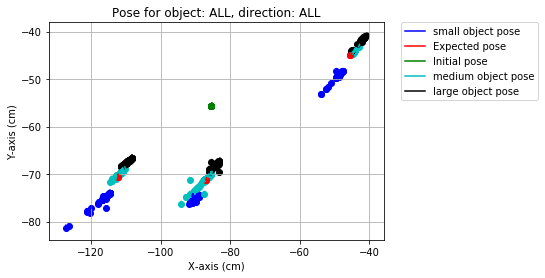

In [4]:
# For data from all groups

poles = ['small', 'medium', 'large']
directions = ['straight', 'left', 'right']
gt = [[-86.89, -71.31, 1.45], [-45.47, -45.00, 0.88], [-112.13, -70.58, 1.78]]
colours = ['b','c','k']

df_all = pd.DataFrame(columns=['size', 'direction', 'x', 'y', 'theta'])
total_filtered = 0


for i, pole in enumerate(poles):
    for ind, direction in enumerate(directions):
        df = combine_records(pole, direction)
        
        # Save data
        output_path = './pre-processed_2/{}_{}.csv'.format(pole, direction)
        df.to_csv(output_path)
        
        x_mean = np.mean(df.x.values)
        y_mean = np.mean(df.y.values)
        theta_mean = np.mean(df.theta.values)
        
        df_all = df_all.append({'size': pole, 'direction': direction, 'x': x_mean, 'y': y_mean, 'theta': theta_mean}, ignore_index=True)
        
        # Plot data
        title=''
        plot_data(df, (gt[ind][0], gt[ind][1], gt[ind][2]), c=colours[i]  ,show=False, l='{} object'.format(pole))
        
print 'Total filtered records: ', total_filtered
print 'Average filtered records: ', total_filtered/180.0
        
df_all.to_csv('./pre-processed/all.csv')

plt.title('Pose for object: ALL, direction: ALL')
plt.show()



In [8]:
"""def get_ground_truth():
    return {'straight': [-86.89, -71.31, 1.45], 
          'left': [-45.47, -45.00, 0.88], 
          'right': [-112.13, -70.58, 1.78]
         }

def scatter_plot_in_direction(direction):
    # ground truth
    gt = get_ground_truth()
        
    pole = 'small'
    title = 'Pose for object: {}, direction: {}'.format(pole, direction)
    df_small, _ = get_measurements(pole, direction)
    plot_data(df_small, (gt[direction][0], gt[direction][1], gt[direction][2]),c='b',show=False,
              l='{} object'.format(pole))

    pole = 'medium'
    title = 'Pose for object: {}, direction: {}'.format(pole, direction)
    df_medium, _ = get_measurements(pole, direction)
    plot_data(df_medium, (gt[direction][0], gt[direction][1], gt[direction][2]),c='c',show=False,
              l='{} object'.format(pole))

    pole = 'large'
    title = 'Pose for object: {}, direction: {}'.format(pole, direction)
    df_large, _ = get_measurements(pole, direction)
    plot_data(df_large, (gt[direction][0], gt[direction][1], gt[direction][2]),c='k',show=False,
              l='{} object'.format(pole))
    
    
    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)
    
    title = 'Pose for object: ALL, direction: {}'.format(direction)
    plt.title(title)
    plt.show()
    #plot_data(df_all, (gt[direction][0], gt[direction][1], gt[direction][2]), title)"""

print "commented"

In [5]:
def get_ground_truth():
    return {'straight': [-86.89, -71.31, 1.45], 
          'left': [-45.47, -45.00, 0.88], 
          'right': [-112.13, -70.58, 1.78]
         }

def scatter_plot_in_direction(direction):
    # ground truth
    gt = get_ground_truth()
        
    pole = 'small'
    title = 'Pose for object: {}, direction: {}'.format(pole, direction)
    df_small  = combine_records(pole, direction)
    plot_data(df_small, (gt[direction][0], gt[direction][1], gt[direction][2]),c='b',show=False,
              l='{} object'.format(pole))

    pole = 'medium'
    title = 'Pose for object: {}, direction: {}'.format(pole, direction)
    df_medium = combine_records(pole, direction)
    plot_data(df_medium, (gt[direction][0], gt[direction][1], gt[direction][2]),c='c',show=False,
              l='{} object'.format(pole))

    pole = 'large'
    title = 'Pose for object: {}, direction: {}'.format(pole, direction)
    df_large = combine_records(pole, direction)
    plot_data(df_large, (gt[direction][0], gt[direction][1], gt[direction][2]),c='k',show=False,
              l='{} object'.format(pole))
    
    
    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)
    
    title = 'Pose for object: ALL, direction: {}'.format(direction)
    plt.title(title)
    plt.show()
    #plot_data(df_all, (gt[direction][0], gt[direction][1], gt[direction][2]), title)

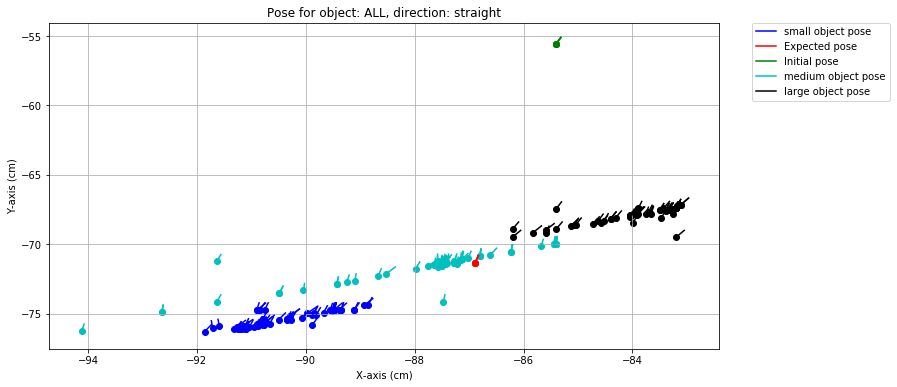

In [16]:
scatter_plot_in_direction('straight')

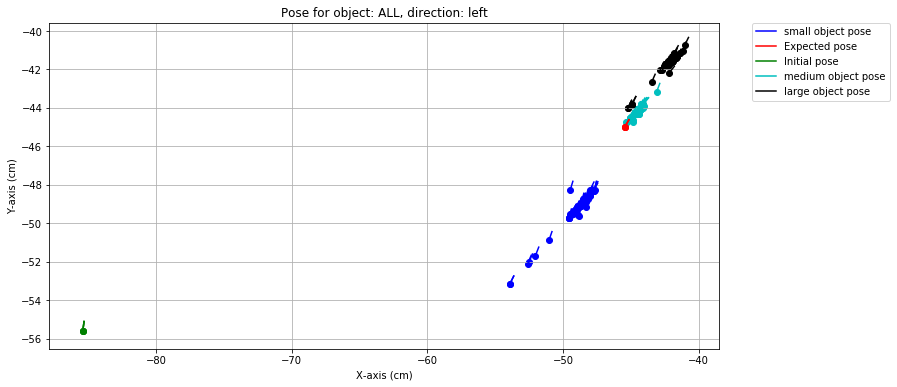

In [17]:
scatter_plot_in_direction('left')

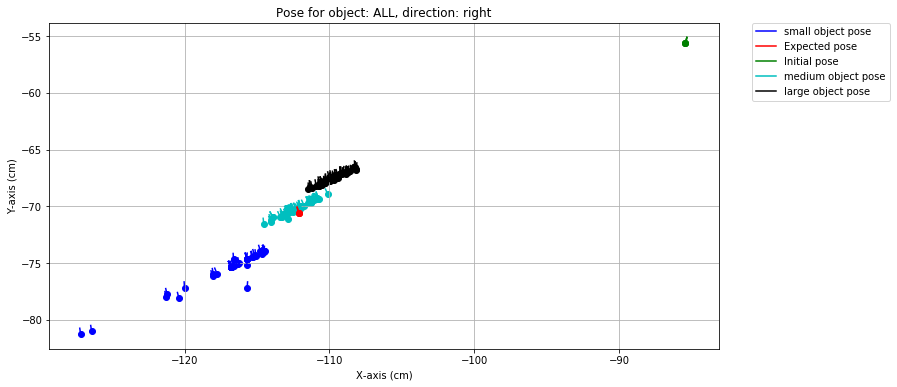

In [18]:
scatter_plot_in_direction('right')

In [12]:
"""def bar_chart_in_direction(direction):
    pole = 'small'
    df_small, _ = get_measurements(pole, direction)

    pole = 'medium'
    df_medium, _ = get_measurements(pole, direction)

    pole = 'large'
    df_large, _ = get_measurements(pole, direction)

    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)

    fig = plt.figure(figsize=(16,16))

    ax = plt.subplot(321)
    sns.distplot(df_small.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('small', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(322)
    sns.distplot(df_small.y.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('small', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()


    ax = plt.subplot(323)
    sns.distplot(df_medium.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('medium', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(324)
    sns.distplot(df_medium.y.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('medium', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()


    ax = plt.subplot(325)
    sns.distplot(df_large.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('large', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(326)
    sns.distplot(df_large.y.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('large', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    plt.show()


    ax = plt.subplot(121)
    sns.distplot(df_all.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('ALL', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(122)
    sns.distplot(df_all.y.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('ALL', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    plt.show()"""
print "commented"

In [6]:
def bar_chart_in_direction(direction):
    pole = 'small'
    df_small = combine_records(pole, direction)

    pole = 'medium'
    df_medium = combine_records(pole, direction)

    pole = 'large'
    df_large = combine_records(pole, direction)

    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)

    fig = plt.figure(figsize=(16,16))

    ax = plt.subplot(331)
    sns.distplot(df_small.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('small', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(332)
    sns.distplot(df_small.y.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('small', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()


    ax = plt.subplot(333)
    sns.distplot(df_small.theta.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('small', direction))
    plt.title('Theta')
    plt.ylabel('Probability density')
    plt.xlabel('Angle (rad)')
    plt.legend()
    
    ax = plt.subplot(334)
    sns.distplot(df_medium.x.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('medium', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(335)
    sns.distplot(df_medium.y.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('medium', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()


    ax = plt.subplot(336)
    sns.distplot(df_medium.theta.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('medium', direction))
    plt.title('Theta')
    plt.ylabel('Probability density')
    plt.xlabel('Angle (rad)')
    plt.legend()
    
    
    
    ax = plt.subplot(337)
    sns.distplot(df_large.x.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('large', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(338)
    sns.distplot(df_large.y.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('large', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()
    
    
    ax = plt.subplot(339)
    sns.distplot(df_large.theta.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('large', direction))
    plt.title('Theta')
    plt.ylabel('Probability density')
    plt.xlabel('Angle (rad)')
    plt.legend()
    plt.tight_layout()
    plt.show()


    ax = plt.subplot(131)
    sns.distplot(df_all.x.values,hist=True, rug=True,
                 label='object: {}, direction: {}'.format('ALL', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(132)
    sns.distplot(df_all.y.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('ALL', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()
    
    ax = plt.subplot(133)
    sns.distplot(df_all.theta.values,hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format('ALL', direction))
    plt.title('Theta')
    plt.ylabel('Probability density')
    plt.xlabel('Angle (rad)')
    
    
    plt.legend()
    plt.tight_layout()
    plt.show()

/home/debaraj/anaconda3/envs/lna/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


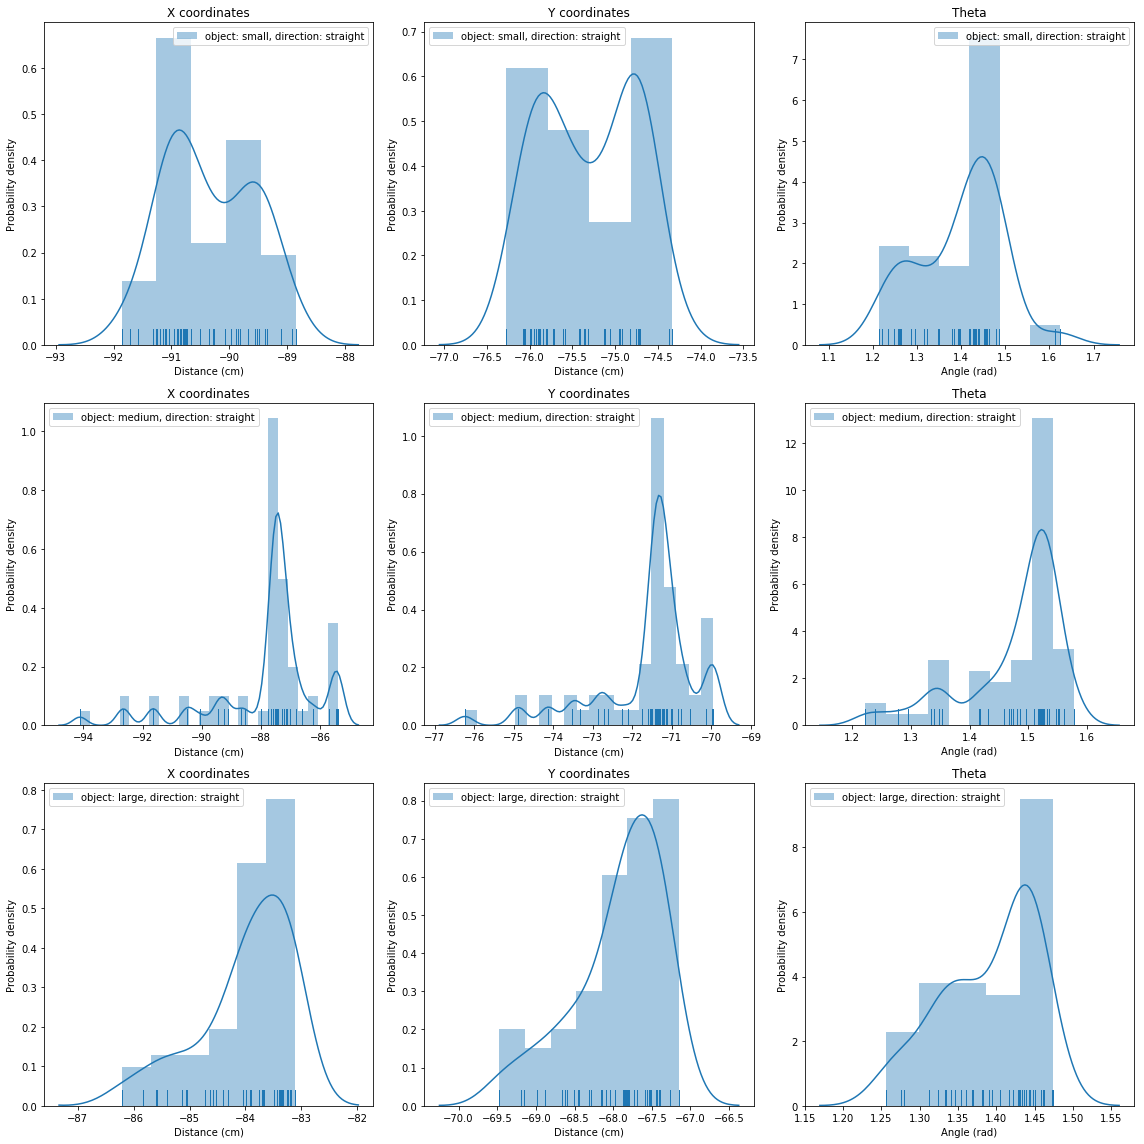

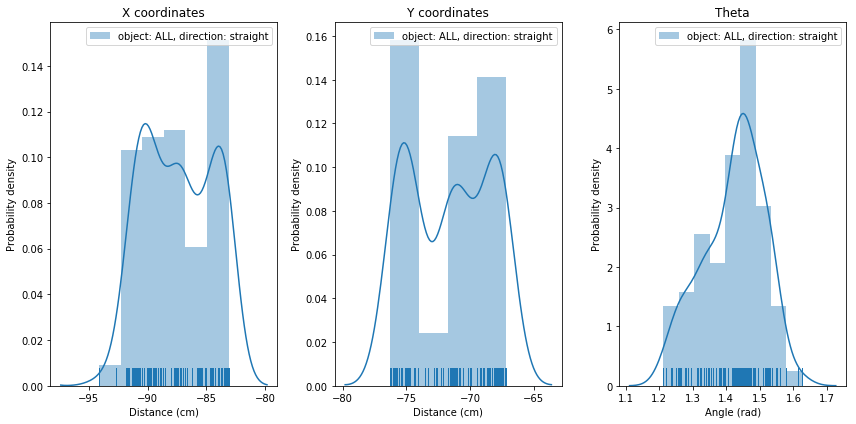

In [7]:
bar_chart_in_direction('straight')

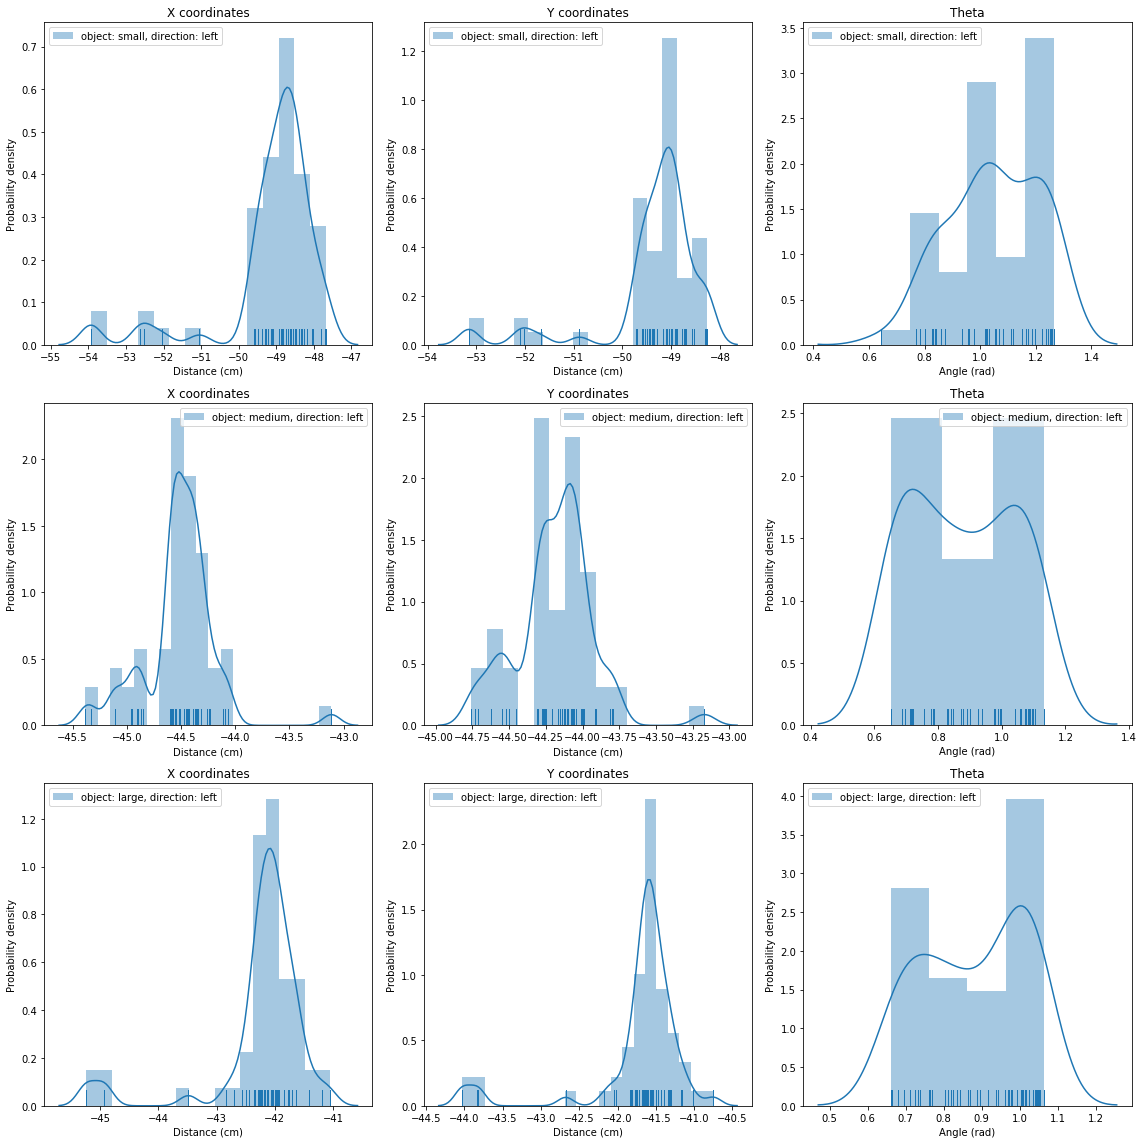

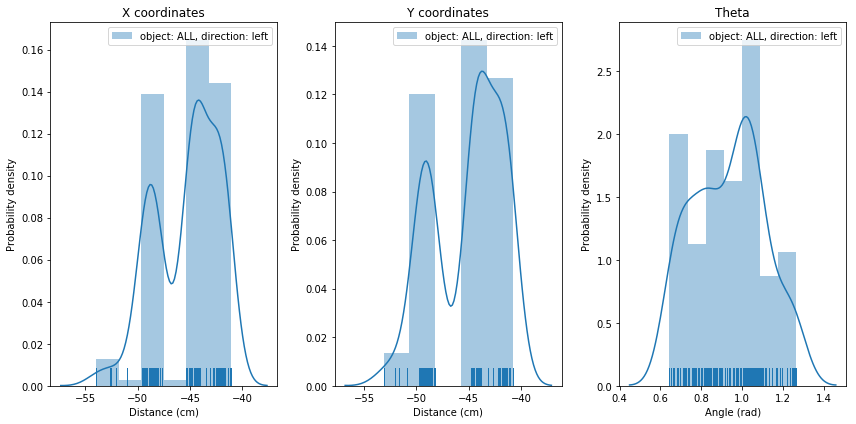

In [8]:
bar_chart_in_direction('left')

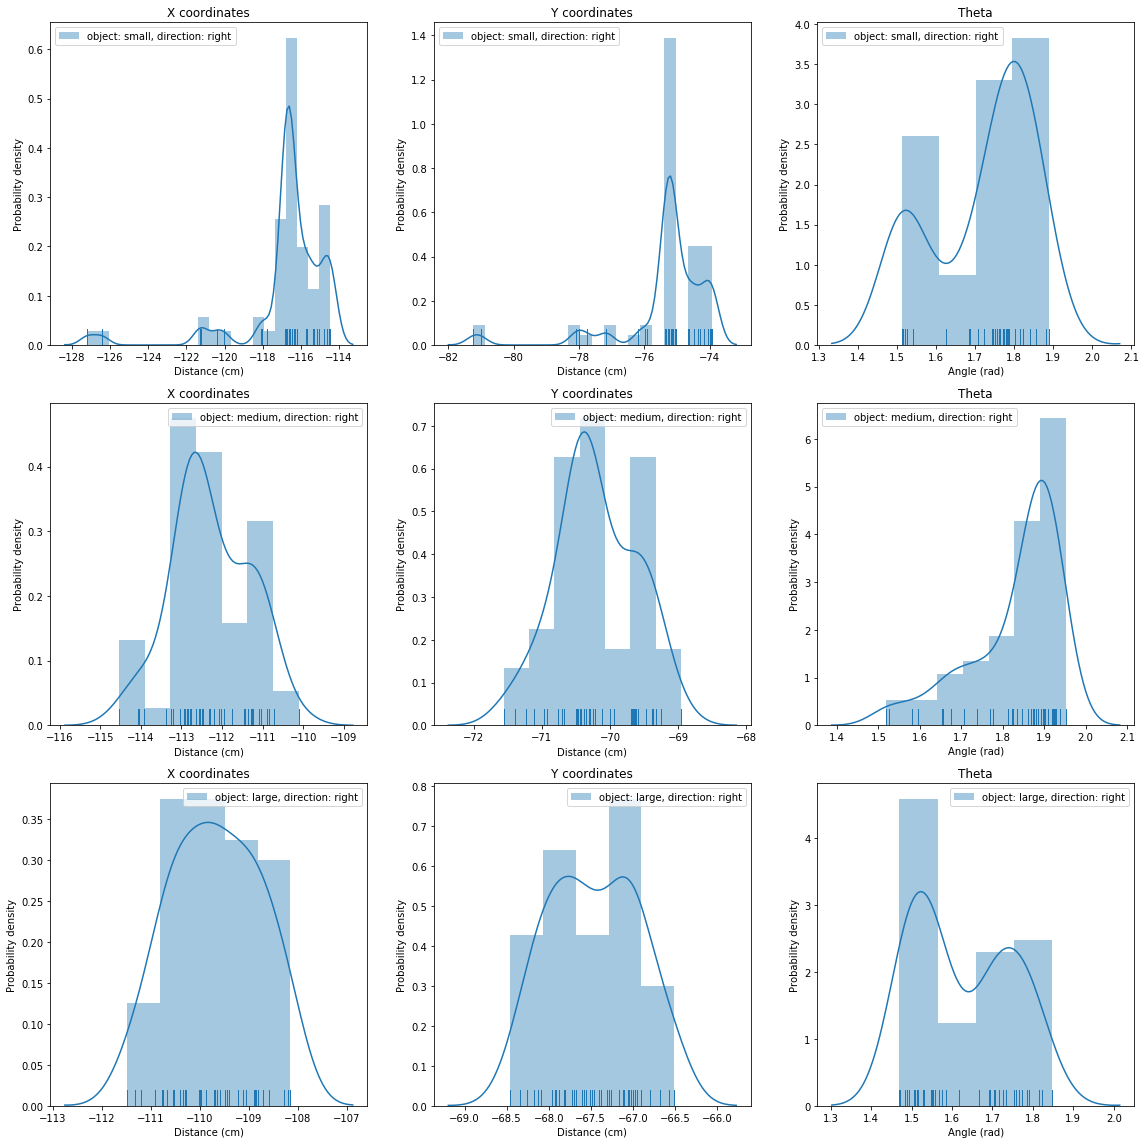

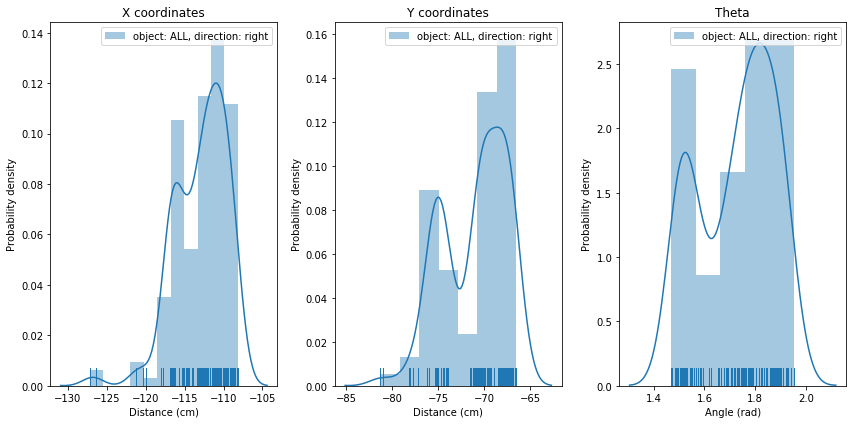

In [10]:
bar_chart_in_direction('right')

In [13]:
"""def print_mean_in_direction(direction):
    pole = 'small'
    df_small, _ = get_measurements(pole, direction)

    pole = 'medium'
    df_medium, _ = get_measurements(pole, direction)

    pole = 'large'
    df_large, _ = get_measurements(pole, direction)

    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)

    mean = df_small.mean(axis=0)
    print 'small: ', mean.x, mean.y, mean.theta

    mean = df_medium.mean(axis=0)
    print 'medium: ', mean.x, mean.y, mean.theta 

    mean = df_large.mean(axis=0)
    print 'large: ', mean.x, mean.y, mean.theta 

    mean = df_all.mean(axis=0)
    print 'all: ', mean.x, mean.y, mean.theta """

In [6]:
def print_mean_in_direction(direction):
    pole = 'small'
    df_small = combine_records(pole, direction)

    pole = 'medium'
    df_medium = combine_records(pole, direction)

    pole = 'large'
    df_large = combine_records(pole, direction)

    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)

    mean = df_small.mean(axis=0)
    print 'small: ', mean.x, mean.y, mean.theta

    mean = df_medium.mean(axis=0)
    print 'medium: ', mean.x, mean.y, mean.theta 

    mean = df_large.mean(axis=0)
    print 'large: ', mean.x, mean.y, mean.theta 

    mean = df_all.mean(axis=0)
    print 'all: ', mean.x, mean.y, mean.theta 

In [26]:
print_mean_in_direction('straight')

small:  -90.34254134358711 -75.31085008599594 1.398354095683486
medium:  -87.84626125240727 -71.6318385774201 1.4760239645127022
large:  -83.99624121272073 -67.9358398432914 1.3911637041279648
all:  -87.39501460290506 -71.62617616890249 1.4218472547747172


In [27]:
print_mean_in_direction('left')

small:  -49.13674104870247 -49.37540880253758 1.0494783989287972
medium:  -44.515053183037274 -44.18641968029558 0.8752722344276009
large:  -42.24641202007801 -41.72758311924061 0.8792133326692728
all:  -45.295068664597245 -45.09144262875539 0.9343265756683312


In [28]:
print_mean_in_direction('right')

small:  -116.76537199917094 -75.34785958274544 1.719503936267233
medium:  -112.281824698913 -70.19942862987907 1.8309550248141493
large:  -109.68229587047946 -67.46310271221607 1.6245105770642008
all:  -112.93113218846953 -71.02746582913355 1.7249595371547086


In [102]:
1-0.0001

In [112]:
poles = ['small', 'medium', 'large']
directions = ['straight', 'left', 'right']

gt = [[-86.89, -71.31, 1.45], [-45.47, -45.00, 0.88], [-112.13, -70.58, 1.78]]
#alpha =  0.05
alpha =  0.0001
"""
# considering two tailed test
http://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/
http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_HypothesisTest-Means-Proportions/BS704_HypothesisTest-Means-Proportions3.html
"""
#Z_limit = 1.960
Z_limit = 3.819

small_st=combine_records(poles[0], directions[0]).values
small_lt=combine_records(poles[0], directions[1]).values
small_rt=combine_records(poles[0], directions[2]).values

mid_st=combine_records(poles[1], directions[0]).values
mid_lt=combine_records(poles[1], directions[1]).values
mid_rt=combine_records(poles[1], directions[2]).values


large_st=combine_records(poles[2], directions[0]).values
large_lt=combine_records(poles[2], directions[1]).values
large_rt=combine_records(poles[2], directions[2]).values



In [120]:
print small_rt.shape,mid_rt.shape,large_rt.shape
print small_lt.shape,mid_lt.shape,large_lt.shape
print small_st.shape,mid_st.shape,large_st.shape

(61, 3) (60, 3) (60, 3)
(60, 3) (61, 3) (60, 3)
(60, 3) (60, 3) (60, 3)


In [124]:
# Combined data
st =  np.vstack((small_st,mid_st,large_st))
lt =  np.vstack((small_lt,mid_lt,large_lt))
rt =  np.vstack((small_rt,mid_rt,large_rt))

mean_st = np.mean(st, axis=0)
mean_lt = np.mean(lt, axis=0)
mean_rt = np.mean(rt, axis=0)

print st.shape, lt.shape, rt.shape 

(180, 3) (181, 3) (181, 3)


In [143]:
# Accuracy and precision: st

accuracy_straight_xpos = 100-np.abs(np.linalg.norm(gt[0][0])-np.linalg.norm(mean_st[0])
                    )/(np.linalg.norm(gt[0][0]))*100

accuracy_straight_ypos = 100-np.abs(np.linalg.norm(gt[0][1])-np.linalg.norm(mean_st[1])
                    )/(np.linalg.norm(gt[0][1]))*100

accuracy_straight_zpos = 100-np.abs(np.linalg.norm(gt[0][2])-np.linalg.norm(mean_st[2])
                    )/(np.linalg.norm(gt[0][2]))*100
stdDev_straight = np.std(st,axis =0)

print "Mean Straight:", mean_st
print "Standard Deviation Straight:", stdDev_straight
print "Accuracy in X: ", accuracy_straight_xpos
print "Accuracy in Y: ", accuracy_straight_ypos
print "Accuracy in theta: ", accuracy_straight_zpos
#print ("Accuracy in angular: ", accuracy_straight_rot)

Mean Straight: [-87.3950146  -71.62617617   1.42184725]
Standard Deviation Straight: [2.88911989 3.13468989 0.08958304]
Accuracy in X:  99.41878857992283
Accuracy in Y:  99.55661734833474
Accuracy in theta:  98.05843136377362


In [145]:
# Accuracy and precision: lt

accuracy_left_xpos = 100-np.abs(np.linalg.norm(gt[1][0])-np.linalg.norm(mean_lt[0])
                    )/(np.linalg.norm(gt[1][0]))*100

accuracy_left_ypos = 100-np.abs(np.linalg.norm(gt[1][1])-np.linalg.norm(mean_lt[1])
                    )/(np.linalg.norm(gt[1][1]))*100

accuracy_left_zpos = 100-np.abs(np.linalg.norm(gt[1][2])-np.linalg.norm(mean_lt[2])
                    )/(np.linalg.norm(gt[1][2]))*100

stdDev_left = np.std(lt,axis =0)

print "Mean left:", mean_lt
print "Standard Deviation Left:", stdDev_left
print "Accuracy in X: ", accuracy_left_xpos
print "Accuracy in Y: ", accuracy_left_ypos
print "Accuracy in theta: ", accuracy_left_zpos
#print ("Accuracy in angular: ", accuracy_straight_rot)

Mean left: [-45.29506866 -45.09144263   0.93432658]
Standard Deviation Left: [3.00487165 3.26057956 0.17359525]
Accuracy in X:  99.6152818662794
Accuracy in Y:  99.79679415832139
Accuracy in theta:  93.82652549223513


In [146]:
# Accuracy and precision: lt

accuracy_rt_xpos = 100-np.abs(np.linalg.norm(gt[2][0])-np.linalg.norm(mean_rt[0])
                    )/(np.linalg.norm(gt[2][0]))*100

accuracy_rt_ypos = 100-np.abs(np.linalg.norm(gt[2][1])-np.linalg.norm(mean_rt[1])
                    )/(np.linalg.norm(gt[2][1]))*100

accuracy_rt_zpos = 100-np.abs(np.linalg.norm(gt[2][2])-np.linalg.norm(mean_rt[2])
                    )/(np.linalg.norm(gt[2][2]))*100

stdDev_rt = np.std(rt,axis =0)

print "Mean left:", mean_rt
print "Standard Deviation Left:", stdDev_rt
print "Accuracy in X: ", accuracy_rt_xpos
print "Accuracy in Y: ", accuracy_rt_ypos
print "Accuracy in theta: ", accuracy_rt_zpos
#print ("Accuracy in angular: ", accuracy_straight_rot)

Mean left: [-112.93113219  -71.02746583    1.72495954]
Standard Deviation Left: [3.32112528 3.4058444  0.1456988 ]
Accuracy in X:  99.28553269555918
Accuracy in Y:  99.366016110607
Accuracy in theta:  96.90783916599486


In [53]:
def get_Z(data, mu_0,i):
    n = np.shape(data)[0]
    #print "n: ",n
    #mu_0=np.mean(data)
    #print "mu_0: ",mu_0
    x  =  data[i]
    #print "x: ",x
    sigma = np.std(data)
    #print "sigma: ", sigma
    #print "::: ",(x -mu_0)/(sigma/np.sqrt(n))
    #print ""
    return (x -mu_0)/(sigma/np.sqrt(n))

def getRejectionIdx(array, mu_0):
    """Null hypothesis is that the true value is mu_0l"""
    """
    https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561
    """
    idx=[]
    for i, x in enumerate(array):
        Z = get_Z(array, mu_0,i)
        mu = np.mean(array)        
        #print mu
        #if ((mu+np.abs(Z))>(mu_0+Z_limit)):
        if (np.abs(Z)>Z_limit):        
            #print "rejecting ",array[i], "; Z: ",Z
            # Hypothesis is false, data needs to be filtered
            idx.append(i)
    
    return idx


def filterData (data, direction):
    gt = [[-86.89, -71.31, 1.45], [-45.47, -45.00, 0.88], [-112.13, -70.58, 1.78]]
    groundTruth = gt[direction]
    idx=[]
    for i in range(0,2):
        array = data[:,i]
        mu_0 = groundTruth[i]
        idx = getRejectionIdx(array,mu_0) 
        #print idx
        data=np.delete(data, idx, axis=0)
    
    return data
    


In [93]:
"""MEDIUM-STRAIGHT"""

def plot_filtered_data(filtered,original, direction,obj):
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(131)    
    fig.suptitle('Filtered data after removing outliers')
    sns.distplot(filtered[:,0],hist=True, rug=True,
                 label='object: {}, direction: {}'.format(obj, direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(132)
    sns.distplot(filtered[:,1],hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format(obj, direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()
    #plt.suptitle('Filtered data after removing outliers')

    ax = plt.subplot(133)
    sns.distplot(filtered[:,2],hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format(obj, direction))
    plt.title('Theta')
    plt.ylabel('Probability density')
    plt.xlabel('Angle (rad)')
    plt.legend()
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()
    
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(131)    
    fig.suptitle('Original data')
    sns.distplot(original[:,0],hist=True, rug=True,
                 label='object: {}, direction: {}'.format(obj, direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(132)
    sns.distplot(original[:,1],hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format(obj, direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()


    ax = plt.subplot(133)
    sns.distplot(original[:,2],hist=True, rug=True,norm_hist=True,
                 label='object: {}, direction: {}'.format(obj, direction))
    plt.title('Theta')
    plt.ylabel('Probability density')
    plt.xlabel('Angle (rad)')
    plt.legend()
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

In [101]:
print scipy.stats.normaltest(mid_st).pvalue

[1.25243237e-05 9.79954365e-06 9.16621853e-05]


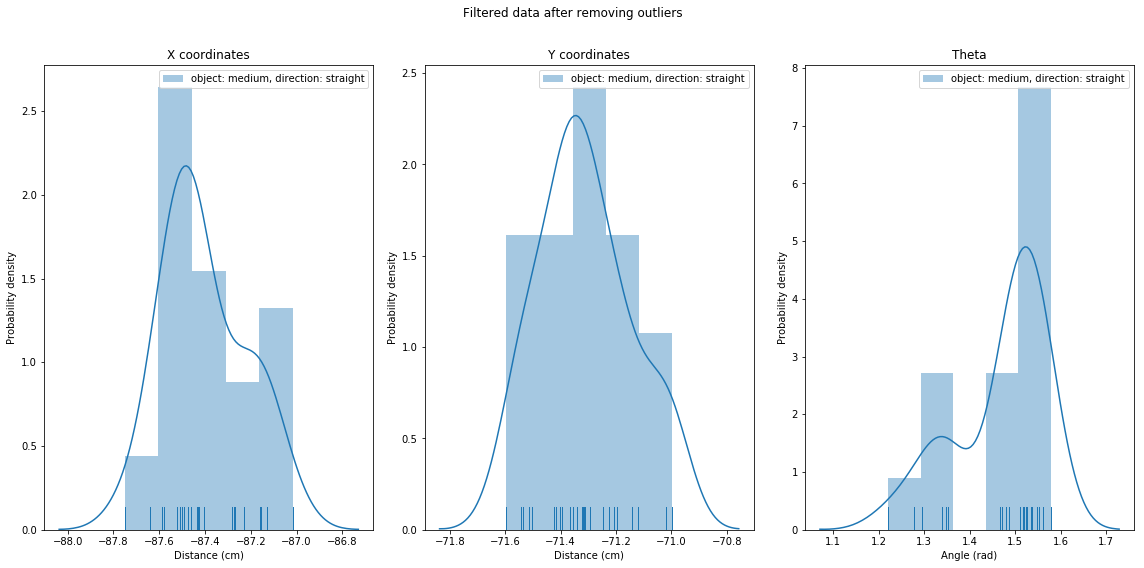

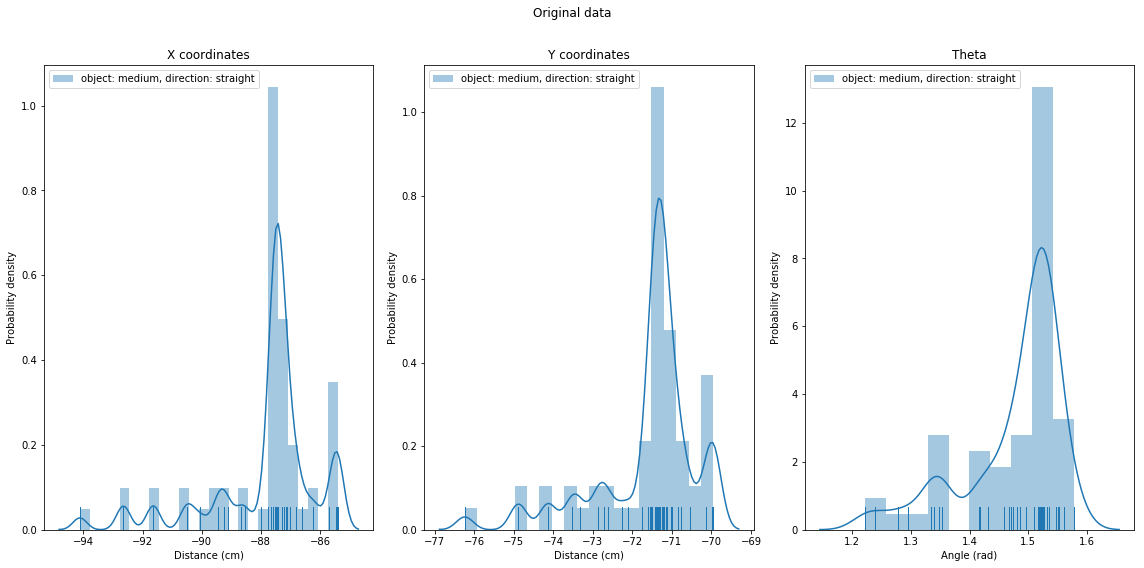

In [151]:

filtered_mid_st = filterData(mid_st,0)
direction = 'straight'
obj = 'medium'

plot_filtered_data(filtered_mid_st,mid_st,direction,obj)


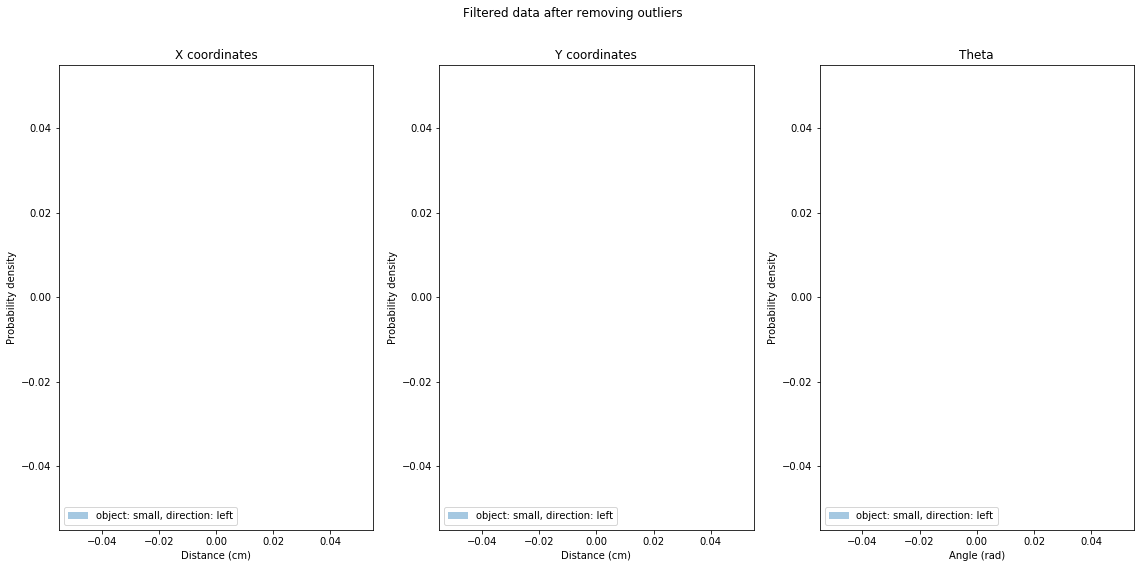

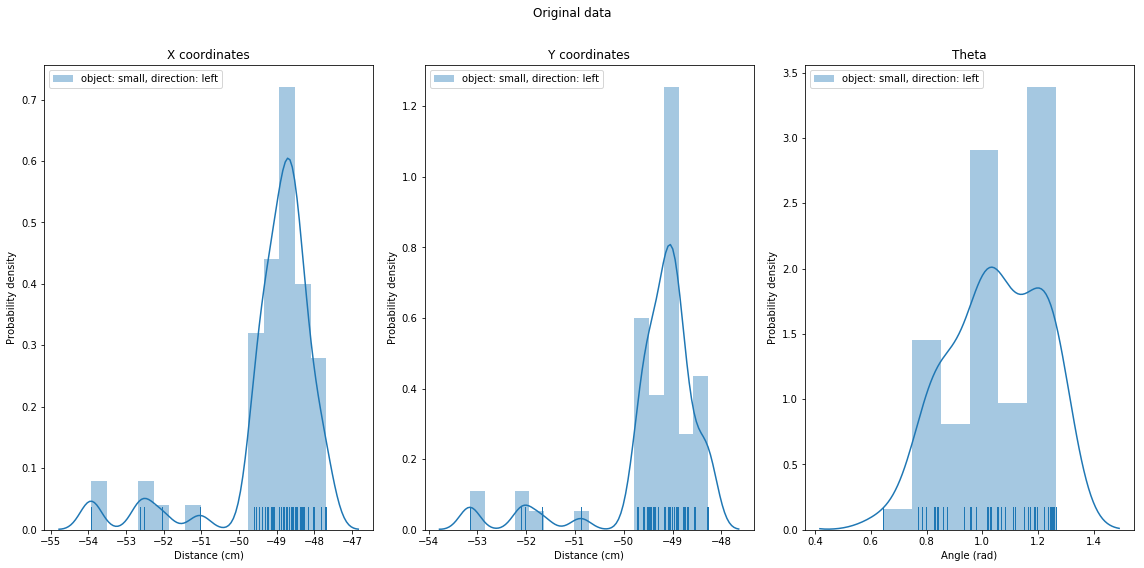

In [148]:
filtered_small_st = filterData(small_lt,0)
direction = 'left'
obj = 'small'

plot_filtered_data(filtered_small_st,small_lt,direction,obj)


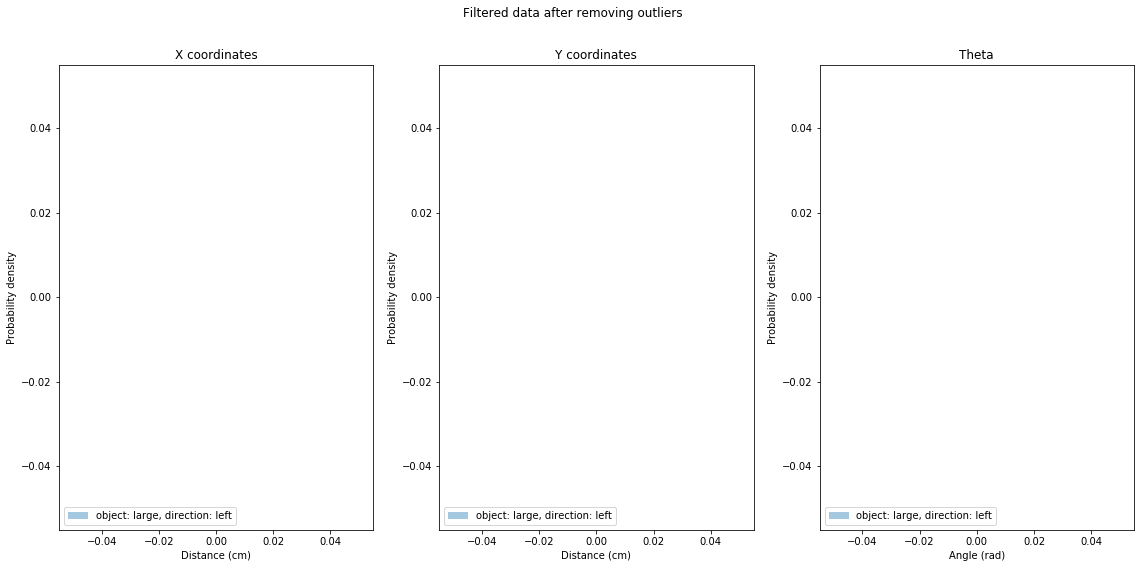

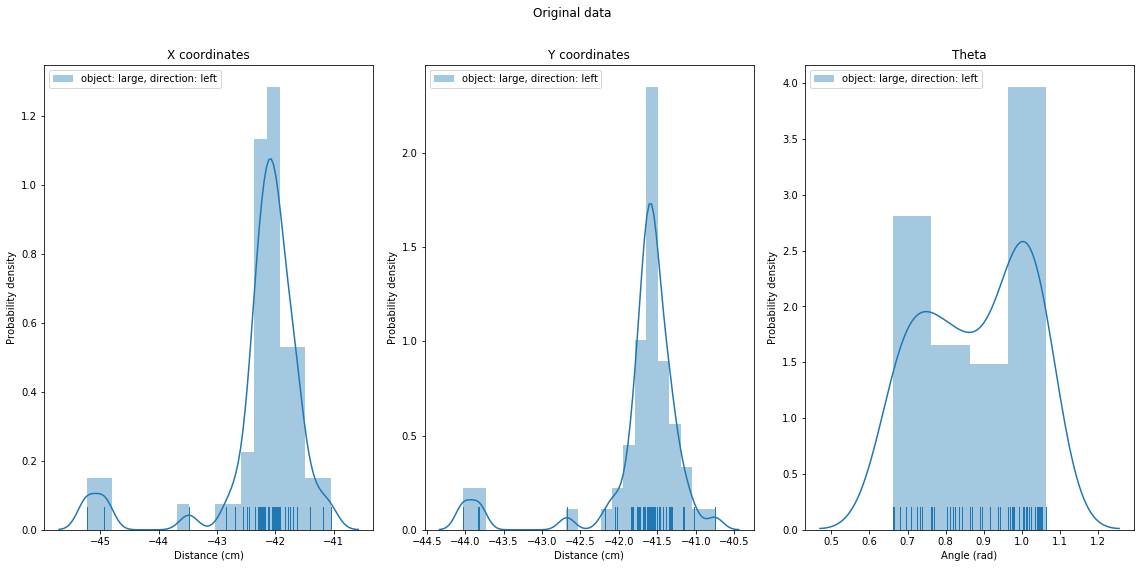

In [149]:
filtered_large_lt = filterData(large_lt,0)
direction = 'left'
obj = 'large'

plot_filtered_data(filtered_large_lt,large_lt,direction,obj)


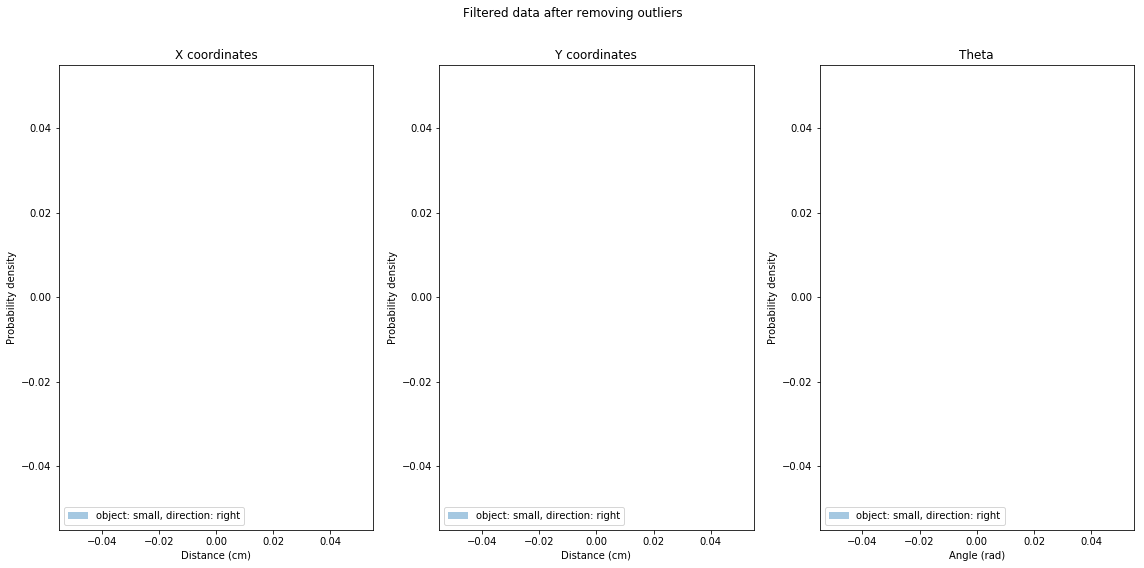

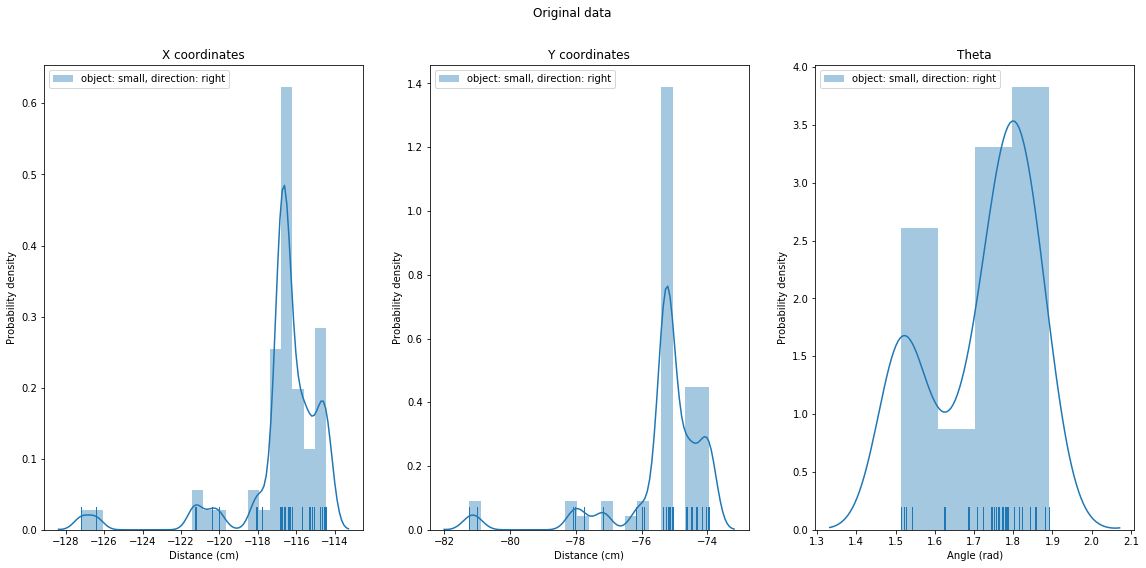

In [150]:
filtered_small_rt = filterData(small_rt,0)
direction = 'right'
obj = 'small'

plot_filtered_data(filtered_small_rt,small_rt,direction,obj)
